In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/CCTASK/creditcardfraud.zip"

Archive:  /content/drive/My Drive/CCTASK/creditcardfraud.zip
  inflating: creditcard.csv          


In [3]:
!pip install searchgrid

  Created wheel for searchgrid: filename=searchgrid-0.2.0-cp36-none-any.whl size=5764 sha256=3a0b34a4eab0e1a7b83dcfebd0189fc0ac9f209370e42c6e652795f572fe9451
  Stored in directory: /root/.cache/pip/wheels/c0/9e/bc/d2faf5fa8b1a478cb8aa6bc255797b0e96d1131b2fcbe2810f
Successfully built searchgrid


### Objective of the Project
The objective of the case study is to predict fraudulent attempts on credit card transactions through machine learning tools. Banks have to be cautious in protecting customers by segregating genuine transactions from fraudulent transactions, which includes skimming. Here we are talking about external frauds which are perpetrated by third parties by manipulating genuine cards, creating counterfeit cards, etc. Hence, we need to create a ML model with statistically important predictor variables in predicting the class of a transaction, fraud or genuine, and thus save money which may have to be paid as chargeback or overheads which may be wasted contacting False Positives customers. We also have to minimize losses on account of False Negatives. Gains from True Positives will be offset by these losses.

### Steps to be undertaken
1.	Data Understanding: The data has been obtained from Kaggle website. On perusal, we have noticed that the data suffers from class imbalance and as such we need to use synthetic data to solve this problem. We intend to use Adasyn or SMOTE depending upon the result;
2.	EDA: After understanding the data, we will perform EDA. Out of 31 columns, 28 columns have been modified using PCA to maintain confidentiality. Hence, scaling of these columns would not be required. We can perform univariate and bi-variate analysis of remaining 3 columns and check for outliers in the dataset. We need to remove outliers without impacting minority class data, as outliers may distort our final result.	Similarly, we need to perform test for data skewness and if found true, we have to make the dataset Gaussian;
3.	Train-Test split: We can divided the data into train, test and validation data but for the presence of minority class imbalance. Hence, we will divide the data into 70:30 ratio for train and test purpose and apply stratified k-fold cross validation to ensure that the model is trained on k-1 groups and then tested on test data. We will then perform standardized scaling of remaining 3 columns. Post this activity, our dataset will be ready for model building;
4.	Model building & hyperparameter Tuning: We will build different models like logistic regression and random forest to see performance of model on training data. We will try to select optimal number of predictor variables using RfE or by checking variance for PCA transformed variables through scree plot. We will also try to improve our scores like AUC, accuracy, sensitivity, specificity, precision, recall and F1 by applying regularizations techniques like lasso regression. The trained model will be applied on test dataset to check the validation scores;
5.	Model evaluation: We will select the appropriate model based on the AUC and recall scores obtained on test dataset. AUC score will tell us how good the model is than random classifier and recall score will tell us the proportion of TP over TP and FN;
6.	Financial Benefit: Lastly, we will compute the financial benefit to the bank on account of selecting the best model.

In [0]:
#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
# basic python libraries for data analysis and visulaization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import scipy.stats.stats as stats
#import plotly.express as px

import sys
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)

#importing data preprocessing and model selection libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from searchgrid import set_grid, make_grid_search


# importing libraries for algorithms
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import lightgbm as lgb

# importing metric libaries
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

### 1. Data Understanding

In [6]:
#INPUT_FILE ="C:/Users/Polu/Desktop/Capstone Project/creditcard.csv"
INPUT_FILE ="/content/creditcard.csv"
# importing the dataset
#card_data = pd.read_csv('C:/Users/Polu/Desktop/Capstone Project/creditcard.csv')
card_data = pd.read_csv(INPUT_FILE)

print(card_data.shape)
card_data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Review comment:

Total around 284k observations are provided. all 31 variables indicates numerical variables. 


In [7]:
#Rechecking total null values in all rows & columns
print('Total null value in the dataset is {}'.format(card_data.isnull().sum().sum()))

Total null value in the dataset is 0


In [8]:
# verify duplicates 

print(f"Number of records appeared to be duplicated {card_data[card_data.duplicated()].shape[0]}")

Number of records appeared to be duplicated 1081


In [9]:
# Deleteing duplicate records
card_data=card_data[~card_data.duplicated()]

print(f"Final Shape of result {card_data.shape}")

Final Shape of result (283726, 31)


In [10]:
# lets understand the target variable i.e Class
classes=card_data['Class'].value_counts()

normal_share = round(classes[0]/card_data['Class'].count()*100,2)
print('Total Normal Share is {} and percentage is {}%'.format(classes[0].sum(), normal_share))

fraud_share = round(card_data['Class'].sum()/len(card_data)*100,2)
print('Total Fraud Share is {} and percentage is {}%'.format(card_data['Class'].sum(), fraud_share))

Total Normal Share is 283253 and percentage is 99.83%
Total Fraud Share is 473 and percentage is 0.17%


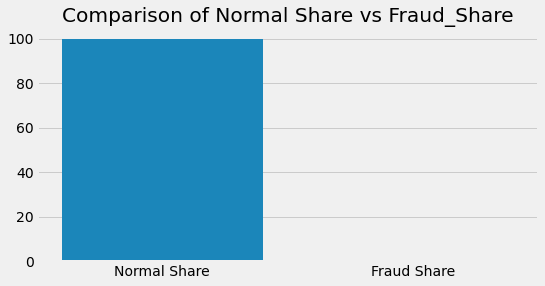

In [11]:
# Comparing %share of normal cases and fraud cases
plt.figure(figsize = (8,4))
sns.barplot(['Normal Share', 'Fraud Share'], [normal_share, fraud_share])
plt.title('Comparison of Normal Share vs Fraud_Share')
plt.show()

Class imbalance in the dataset is clearly visible here

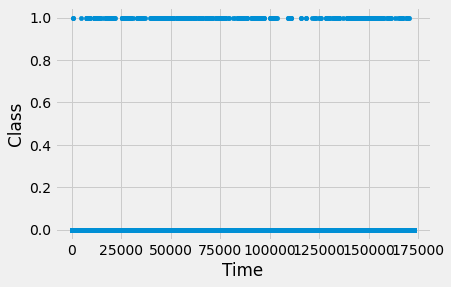

In [0]:
card_data.plot(kind='scatter', x='Time', y='Class')

There is no visible pattern seen here between the time and the target variable

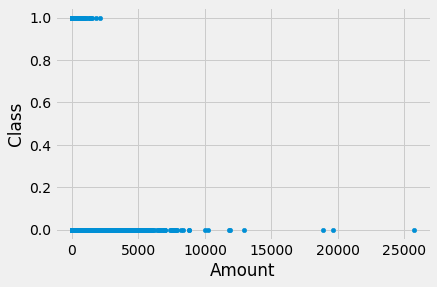

In [0]:
card_data.plot(kind='scatter', x='Amount', y='Class')

It is clearly visible that the amount involved with fraudulent transaction is relatively smaller when compared to total size of the card transaction

### 2. Exploratory Data Analysis

In [0]:
#Checking simple descriptive statistics for three predictor variables which has not been converted into PCA variables
card_data[['Time', 'Amount', 'Class']].describe()

,Time,Amount,Class
count,283726.000000,283726.000000,283726.000000
mean,94811.077600,88.472687,0.001667
std,47481.047891,250.399437,0.040796
min,0.000000,0.000000,0.000000
25%,54204.750000,5.600000,0.000000
50%,84692.500000,22.000000,0.000000
75%,139298.000000,77.510000,0.000000
max,172792.000000,25691.160000,1.000000


In [0]:
#There is a huge jump in amount data, from 3rd quartile onward
# We need to further check the presence of outliers in the data
card_data[['Amount']].describe([.80,.85,.90,.95,.99,.995,.999])

,Amount
count,283726.000000
mean,88.472687
std,250.399437
min,0.000000
50%,22.000000
80%,100.000000
85%,140.000000
90%,203.380000
95%,365.337500
99%,1018.965000


We can see from the above table that there are outliers from 99% onwards

In [12]:
card_data[card_data['Amount'] >= 3000].Class.value_counts()

0    289
Name: Class, dtype: int64

Around 289 cases are for transactions over 3000. All these cases were normal transactions and hence we can safely remove these records from model building without loss of information and at the same time protect the output from outliers.

In [13]:
card_data[card_data['Amount'] <=0].Class.value_counts()

0    1783
1      25
Name: Class, dtype: int64

Around 25 cases indicates the transaction amount is less than or equal to zero amount, out of which 25 appears to be fruad. Since entrire approch is to protect the customer from finaincial fraud, we have not seen any reasons to include this data for the modelling purpose. However, it will lead to loss of 25 minority data.

In [14]:
# Filter all rows for which the amount is more than 3000 at 99.9% and the amount is less than or equal to Zero
card_filtered = card_data[(card_data['Amount'] <= 3000) & (card_data['Amount'] >0) ]
  
# Print the new dataframe 
card_filtered.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
# Print the shape of the dataframe 
card_filtered.shape

(281634, 31)

In [0]:
card_filtered.Class.value_counts()

0    281186
1       448
Name: Class, dtype: int64

We are not losing any minority class data due to trimming the dataset

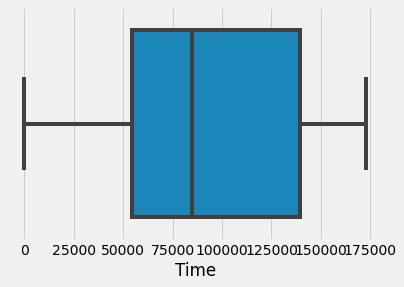

In [0]:
# understanding the distribution of Time columns
sns.boxplot(x = card_filtered['Time'])
plt.show()

In [0]:
#Understanding the total amount involved in fraudulent transactions
#pd.set_option('display.float_format', '{:.2f}'.format)
_temp=card_filtered[['Amount', 'Class']]
_temp.groupby('Class').sum()

,Amount
Class,
0,2.376497e+07
1,5.859139e+04


In [15]:
#creating a dataframe of only fraudulent transactions to perform further analysis
card_class_filtered = card_data[card_data['Class'] == 1]
fraud_per_tran = round(card_class_filtered['Amount'].sum()/len(card_class_filtered),2)
print('Average Fraud amount per fraudulent transaction is Euro {}'.format(fraud_per_tran))

Average Fraud amount per fraudulent transaction is Euro 123.87


In [0]:
#Converting time from seconds to hours
card_class_filtered['Time']=card_class_filtered.Time/3600

In [17]:
#bucketing data on the basis of time and checking any relationship between the time of tran and amount & number of fraud 
_temp=card_class_filtered[['Time', 'Amount', 'Class']]
_temp['Bucket'] = pd.cut(_temp['Time'], [-0.1,4.8,9.6,14.4,19.2,24,28.8,33.6,38.4,43.2,49])
_temp.head()

,Time,Amount,Class,Bucket
541,0.112778,0.00,1,"(-0.1, 4.8]"
623,0.131111,529.00,1,"(-0.1, 4.8]"
4920,1.239444,239.93,1,"(-0.1, 4.8]"
6108,1.940556,59.00,1,"(-0.1, 4.8]"
6329,2.088611,1.00,1,"(-0.1, 4.8]"


In [0]:
_temp.groupby('Bucket').sum()

,Time,Amount,Class
Bucket,,,
"(-0.1, 4.8]",114.403889,2900.66,42
"(4.8, 9.6]",343.133333,5920.76,48
"(9.6, 14.4]",927.006667,7215.95,79
"(14.4, 19.2]",963.081944,10758.38,58
"(19.2, 24.0]",975.911111,5673.19,45
"(24.0, 28.8]",1574.915833,4964.37,59
"(28.8, 33.6]",342.527500,1199.32,11
"(33.6, 38.4]",1226.818056,8362.53,34
"(38.4, 43.2]",2665.035556,8796.47,65


We cannot infer from above if there is any relationship between specific hour of day and volume of fraudulent transactions. There is no pattern here.

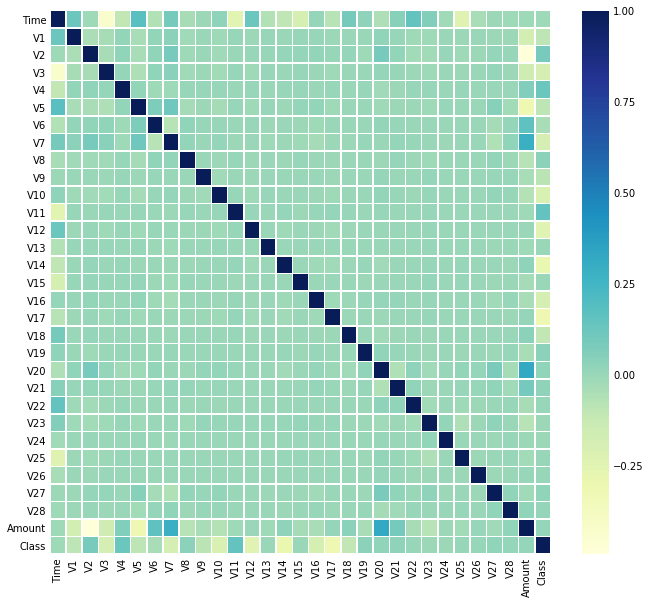

In [0]:
_corr=card_filtered.corr()
plt.figure(figsize=(10,10))
# sns.heatmap(_corr)
# plt.show()

sns.heatmap(_corr,linewidths=.5,cmap="YlGnBu")
plt.show()

Above correlation diagram deos not indicate any strong correlations. In this case we can consider that data could be in the form of non linear relationship.

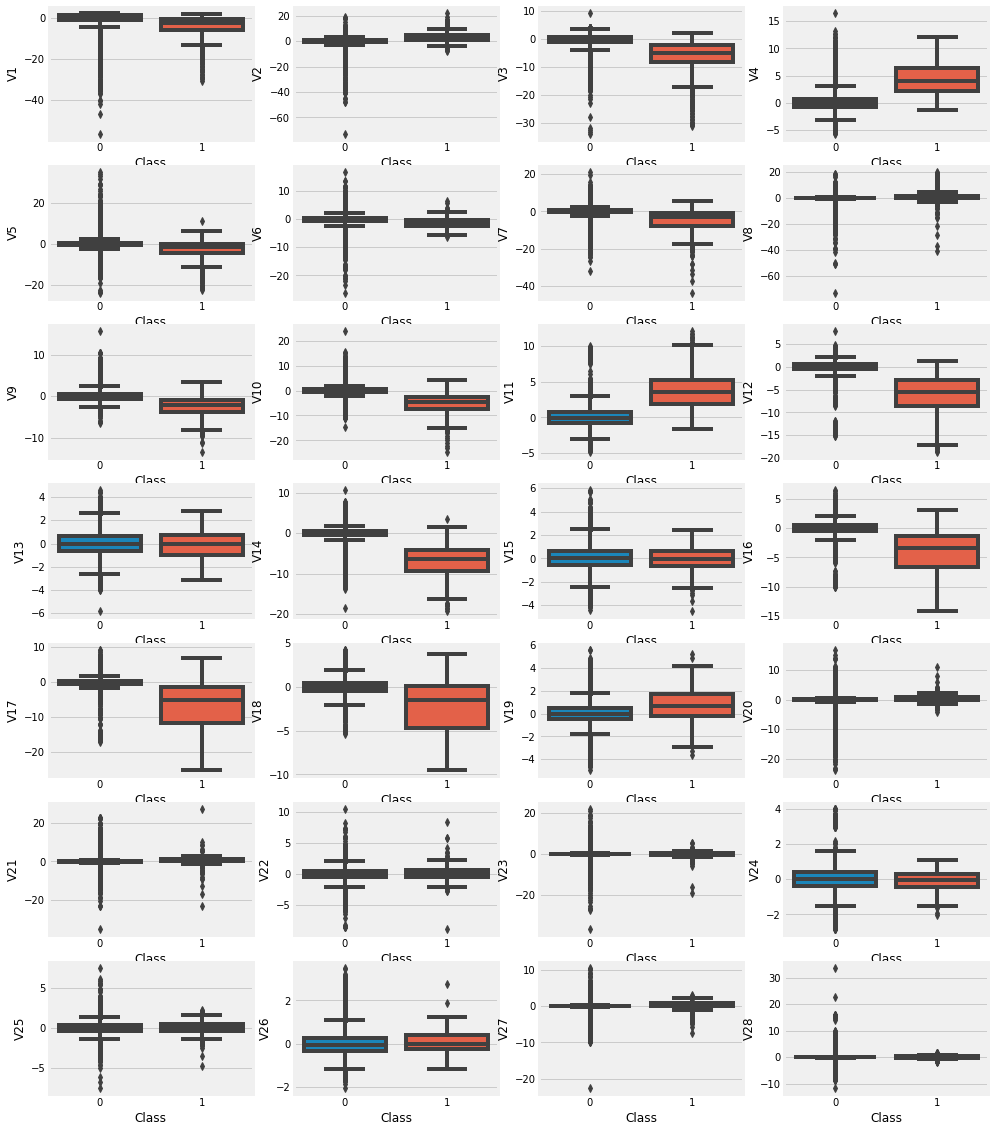

In [0]:
columns =list(card_filtered.columns)
columns.remove("Class")
columns.remove("Time")
columns.remove("Amount")

plt.figure(figsize=(15,20))
for i in range(0,28):
  plt.subplot(7,4,i+1)
  sns.boxplot(data =card_filtered, y=columns[i],x="Class")
plt.show()

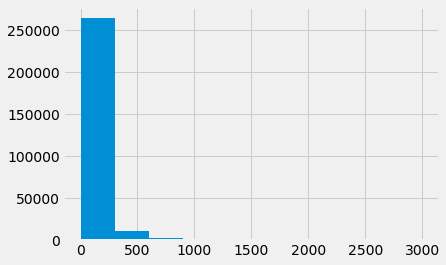

In [0]:
card_filtered.Amount.hist()

### Remaks 

Indicates Amount skwed will try to normalize and see the results


### Review Remarks
The above box plot does not indicate presnece of any outliers in the data. We have already filtered those transactions where amount is more than 3000. All the above variables are PCA transformed variables


### Creating Functions

In [0]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import make_scorer                                                                                      
from imblearn.metrics import geometric_mean_score as gmean                           
from imblearn.metrics import make_index_balanced_accuracy as iba
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer

class data_object:
  
  train =None 
  test = None
  X_train = None 
  y_train = None 

  X_test = None 
  y_train = None
  scal =None
  X_resampled = None
  y_resampled = None

  pow_X_train = None 
  pow_X_test = None 

  

    

  def __init__(self,data):
    self.original_data = data
    self.columns = data.columns
    self.results = pd.DataFrame()
    
    
  
  #frame work used for spliting training and test data set
  def traintestsplit(self) :
    self.train,self.test =train_test_split(self.original_data,random_state =44,train_size =0.75,stratify = self.original_data.Class)
    print(f"Train data set Shape {self.train.shape}")
    print(f"Test data set Shape {self.test.shape}")
    self.X_train = self.train.drop("Class",axis=1)
    self.y_train = self.train[["Class"]]
    self.X_test =self.test.drop("Class",axis=1)
    self.y_test = self.test[["Class"]]

    print(f"X Train shape {self.X_train.shape}, Y Train Shape {self.y_train.shape}, Number of +ve classes {self.y_train[self.y_train==1].count()}")
    print(f"X Train shape {self.X_test.shape}, Y Train Shape {self.y_test.shape}, Number of +ve classes {self.y_test[self.y_test==1].count()}")

#power transform 
  def power_transform(self):
    _trans = PowerTransformer()
    self.pow_X_train = self.X_train.copy()
    self.pow_X_test = self.X_test.copy()
    _trans.fit(self.X_train[["Amount"]])
    self.pow_X_train[["Amount"]] = _trans.transform(self.X_train[["Amount"]])
    self.pow_X_test[["Amount"]] = _trans.transform(self.X_test[["Amount"]])


#framework used for data scaling
  def data_scaling(self,lst_columns):
    self.scal = StandardScaler()
    self.X_train[lst_columns]=self.scal.fit_transform(self.X_train[lst_columns])
    self.X_test[lst_columns]=self.scal.transform(self.X_test[lst_columns])

#framework used for samplings 
  def resampling(self,_type="RandomOverSampler"):
    if _type == "RandomOverSampler":
      ros = RandomOverSampler(random_state=40)
      self.X_resampled, self.y_resampled = ros.fit_resample(self.X_train, self.y_train)
    if _type == "SMOTE":
      ros = SMOTE(sampling_strategy =0.03,random_state=40,k_neighbors=5)
      self.X_resampled, self.y_resampled = ros.fit_resample(self.X_train, self.y_train)
    if _type == "ADASYN":
      ros = SMOTE(sampling_strategy =0.03,random_state=40,k_neighbors=5)
      self.X_resampled, self.y_resampled = ros.fit_resample(self.X_train, self.y_train)
    if _type == "RandomUnderSampler":
      ros = RandomUnderSampler(sampling_strategy =0.1,random_state=40)
      self.X_resampled, self.y_resampled = ros.fit_resample(self.X_train, self.y_train)
    
    if _type == "SMOTEENN":
      ros = SMOTEENN(sampling_strategy =0.2,random_state=40)
      self.X_resampled, self.y_resampled = ros.fit_resample(self.X_train, self.y_train)

      



    self.X_resampled = pd.DataFrame(self.X_resampled)
    self.X_resampled.columns = self.X_train.columns
    self.y_resampled = pd.DataFrame(self.y_resampled)
    self.y_resampled.columns = self.y_train.columns
    print(f"X Train shape {self.X_resampled.shape}, Y Train Shape {self.y_resampled.shape}, Number of +ve classes {self.y_resampled[self.y_resampled==1].count()}")
      
    
#framework using for multiple grid searches and save results
  def multiple_estimators(self,_estimators,_cv,_scoring):
    
    for i in range(len(_estimators)):
      self.train_estimator(_estimators[i],_cv,_scoring)
      

    #return self.results

#framework using for multiple grid searches and save results
  def train_estimator(self,_estimators,_cv,_scoring):
      gmean_iba = iba(alpha=0.1, squared=True)(gmean)                                      
      gmean_iba_scorer = make_scorer(gmean_iba)
      #precision_cust = make_scorer(precision_score,pos_label=1)
      if _scoring == "gmeans":
        search = make_grid_search(_estimators, cv=_cv, scoring=gmean_iba_scorer,return_train_score=True)
      else:
        search = make_grid_search(_estimators, cv=_cv, scoring=_scoring,return_train_score=True)
      search.fit(self.X_resampled, self.y_resampled)

      # print(f"debug,{}")
      results_frame =pd.DataFrame({"Model":[type(_estimators).__name__ for i in range(len(search.cv_results_["mean_test_score"]))],
          "meat_test_score" :search.cv_results_["mean_test_score"],
          "mean_train_score":search.cv_results_["mean_train_score"],
          "parms":search.cv_results_["params"],
          "scoring":[_scoring for i in range(len(search.cv_results_["mean_test_score"]))] })    
      for i in range(_cv):  
        key="split{}_test_score".format(i)
        key1 ="split{}_train_score".format(i)
        results_frame[f"test_{i}"]=list(search.cv_results_[key])
        results_frame[f"train_{i}"]=list(search.cv_results_[key1])     
      
      if self.results.empty:
        self.results = results_frame
      else:
        self.results =pd.concat([self.results,results_frame]) 
  

  def display_stats(self,type,preditc_prob,y_true,verbose=0):
    print(f"{type} Result")
    measures = pd.DataFrame(columns=["Prob","Accuracy","Sensitivity","Precision","TP","FN","TN","FP"])
    for i in np.arange(0,1,0.05):
      y_pre = [1 if j>=i else 0 for j in preditc_prob]
      _mat = confusion_matrix(y_true,y_pre)
      tn, fp, fn, tp = _mat.ravel()
      _accracy = (tn+tp) / (tn+tp+fn+fp)
      _sensitivity = tp / (tp+fn)
      #_specificity =tn / (tn+fp)
      _precision = tp / (fp + tp)
      _item={"Prob":i,"Accuracy":_accracy,"Sensitivity":_sensitivity,"Precision":_precision,"TP":tp,"FN":fn,"TN":tn,"FP":fp}
      measures=measures.append(_item,ignore_index=True )

    _temp =pd.melt( measures,id_vars=["Prob"],value_vars=["Accuracy","Sensitivity","Precision"])

    plt.figure(figsize=(5,5))
    sns.lineplot(data = _temp,x="Prob",y="value",hue="variable")
    plt.title("Indicative scores with Probability to consider cut off")
    plt.xlabel("Probability")
    plt.ylabel("Values")
    plt.show()
    if verbose==1 :
      display(measures)
    


  def model_evaluation(self,model,isPreTrained =False):
    model.fit(self.X_resampled,self.y_resampled)
    # self.display_stats("Test",model.predict_proba(self.X_resampled)[:,1],self.y_resampled,0)
    # self.display_stats("Test",model.predict_proba(self.X_test)[:,1],self.y_test,1)

    print("Train cross validation \n \n")
    print(classification_report(self.y_train,model.predict(self.X_train)))
    cf_matrix = confusion_matrix(self.y_train, model.predict(self.X_train))
    plt.figure(figsize=(5,5))
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    
    group_percentages=list(cf_matrix.flatten()[:2] / cf_matrix.sum(axis=1)[0]) + list(cf_matrix.flatten()[2:] / cf_matrix.sum(axis=1)[1])
    group_percentages=["{0:.2%}".format(value) for value in group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

    print(f"Train Score {gmean(self.y_train, model.predict(self.X_train))}")

    print("test cross validation \n \n")

    print(classification_report(self.y_test,model.predict(self.X_test)))
    plt.figure(figsize=(5,5))
    cf_matrix = confusion_matrix(self.y_test, model.predict(dataobj1.X_test))
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    #group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    group_percentages=list(cf_matrix.flatten()[:2] / cf_matrix.sum(axis=1)[0]) + list(cf_matrix.flatten()[2:] / cf_matrix.sum(axis=1)[1])
    group_percentages=["{0:.2%}".format(value) for value in group_percentages]
    print(group_percentages)
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.show()

    print(f"Test Score {gmean(self.y_train, model.predict(self.X_train))}")

In [0]:
dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.power_transform()
dataobj1.data_scaling(["Amount","Time"])

Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64


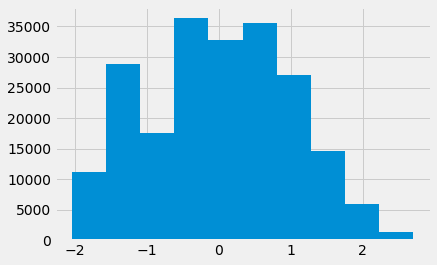

In [0]:
#transformed Data Set
dataobj1.pow_X_train.Amount.hist()

# Analysing power transformed vs Normal Data Set 

In [0]:
from sklearn.metrics import f1_score,roc_auc_score,precision_score,recall_score

def print_scores(y_true,y_pred):
  print ("F1 Score {:.2f} Micro {:.2f} Macro {:.2f}".format(f1_score(y_true,y_pred),f1_score(y_true,y_pred,average='micro'),f1_score(y_true,y_pred,average='macro')))
  print ("roc_auc_score Score {:.2f} Micro {:.2f} Macro {:.2f}".format(roc_auc_score(y_true,y_pred),roc_auc_score(y_true,y_pred,average='micro'),roc_auc_score(y_true,y_pred,average='macro')))
  print ("precision_score Score {:.2f} Micro {:.2f} Macro {:.2f}".format(precision_score(y_true,y_pred),precision_score(y_true,y_pred,average='micro'),precision_score(y_true,y_pred,average='macro')))
  print ("recall_score Score {:.2f} Micro {:.2f} Macro {:.2f}".format(recall_score(y_true,y_pred),recall_score(y_true,y_pred,average='micro'),recall_score(y_true,y_pred,average='macro')))
  print ("gmean Score {:.2f} Micro {:.2f} Macro {:.2f}".format(gmean(y_true,y_pred),gmean(y_true,y_pred,average='micro'),gmean(y_true,y_pred,average='macro')))    
  

In [0]:
# dataobj1 = data_object(card_filtered)
# dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
# dataobj1.traintestsplit()
# dataobj1.power_transform()
# dataobj1.data_scaling(["Amount","Time"])


model = LogisticRegression(C=0.1)
model.fit(dataobj1.X_train,dataobj1.y_train)

print_scores(dataobj1.y_train,model.predict(dataobj1.X_train))



print("\n Power Transform results")
model.fit(dataobj1.pow_X_train,dataobj1.y_train)
print_scores(dataobj1.y_train,model.predict(dataobj1.pow_X_train))


F1 Score 0.74 Micro 1.00 Macro 0.87
roc_auc_score Score 0.81 Micro 0.81 Macro 0.81
precision_score Score 0.89 Micro 1.00 Macro 0.94
recall_score Score 0.63 Micro 1.00 Macro 0.81
gmean Score 0.79 Micro 1.00 Macro 0.81

 Power Transform results
F1 Score 0.74 Micro 1.00 Macro 0.87
roc_auc_score Score 0.81 Micro 0.81 Macro 0.81
precision_score Score 0.89 Micro 1.00 Macro 0.94
recall_score Score 0.63 Micro 1.00 Macro 0.81
gmean Score 0.79 Micro 1.00 Macro 0.81


### Remaks 

Above results indicates not much differeces between power transformed data Set and Original Data set standard sclaed data set. hence we will go with the original data set with after scaled amount and time.



### Resampling Strategies

Trying with the different oversampling and combination sampling stratagies, like Random over sample /  SOMTE / ADASYN

Trial will be conducted with the plain logistic regression to understand which model will provide a better seperatability and scoring parameter. Based on this observation we will deside which type of sampling technique can be considered.


*   Model will be trained with simple logistic regression on over sample / under sample data set
*   See the performence on both original train data set (prior to extended sampleing) and test data set


Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X Train shape (421778, 30), Y Train Shape (421778, 1), Number of +ve classes Class    210889
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train cross validation 
 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    210889
           1       0.06      0.92      0.11       336

   micro avg       0.98      0.98      0.98    211225
   macro avg       0.53      0.95      0.55    211225
weighted avg       1.00      0.98      0.99    211225



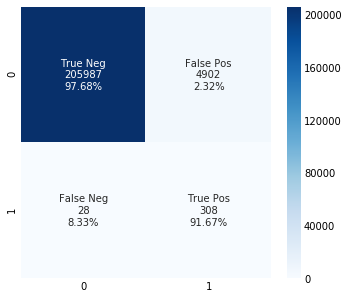

C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Score 0.9462342463789908
test cross validation 
 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70297
           1       0.06      0.90      0.11       112

   micro avg       0.98      0.98      0.98     70409
   macro avg       0.53      0.94      0.55     70409
weighted avg       1.00      0.98      0.99     70409

['97.74%', '2.26%', '9.82%', '90.18%']


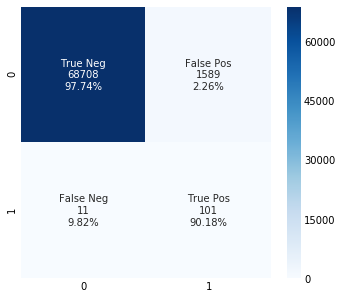

Test Score 0.9462342463789908


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling()
model = LogisticRegression(C=0.1)
dataobj1.model_evaluation(model)

Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X Train shape (217215, 30), Y Train Shape (217215, 1), Number of +ve classes Class    6326
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210889
           1       0.73      0.83      0.78       336

   micro avg       1.00      1.00      1.00    211225
   macro avg       0.86      0.91      0.89    211225
weighted avg       1.00      1.00      1.00    211225



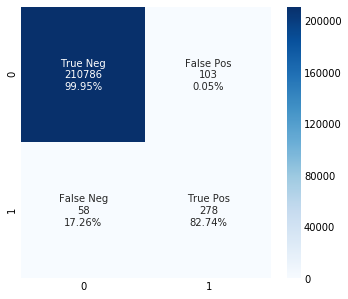

C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Score 0.9093826765521869
test cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70297
           1       0.65      0.80      0.72       112

   micro avg       1.00      1.00      1.00     70409
   macro avg       0.83      0.90      0.86     70409
weighted avg       1.00      1.00      1.00     70409

['99.93%', '0.07%', '19.64%', '80.36%']


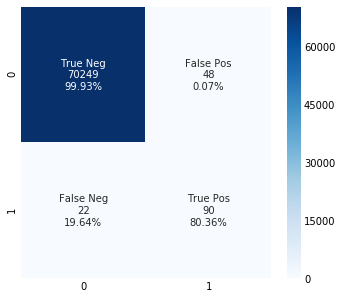

Test Score 0.9093826765521869


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("SMOTE")
model = LogisticRegression(C=0.1)
model.fit(dataobj1.X_resampled,dataobj1.y_resampled)

dataobj1.model_evaluation(model)

Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X Train shape (217215, 30), Y Train Shape (217215, 1), Number of +ve classes Class    6326
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210889
           1       0.73      0.83      0.78       336

   micro avg       1.00      1.00      1.00    211225
   macro avg       0.86      0.91      0.89    211225
weighted avg       1.00      1.00      1.00    211225



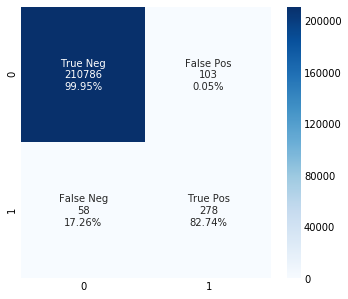

C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Score 0.9093826765521869
test cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70297
           1       0.65      0.80      0.72       112

   micro avg       1.00      1.00      1.00     70409
   macro avg       0.83      0.90      0.86     70409
weighted avg       1.00      1.00      1.00     70409

['99.93%', '0.07%', '19.64%', '80.36%']


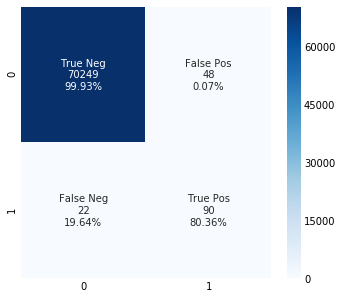

Test Score 0.9093826765521869


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("ADASYN")
model = LogisticRegression(C=0.1)
model.fit(dataobj1.X_resampled,dataobj1.y_resampled)
dataobj1.model_evaluation(model)

Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X Train shape (252769, 30), Y Train Shape (252769, 1), Number of +ve classes Class    42176
dtype: int64


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train cross validation 
 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    210889
           1       0.20      0.88      0.32       336

   micro avg       0.99      0.99      0.99    211225
   macro avg       0.60      0.94      0.66    211225
weighted avg       1.00      0.99      1.00    211225



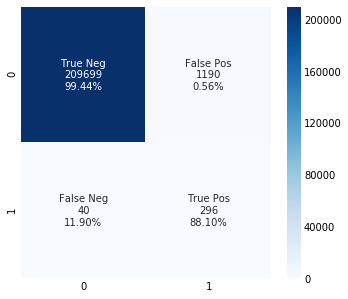

C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Score 0.9359387594511233
test cross validation 
 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     70297
           1       0.20      0.86      0.32       112

   micro avg       0.99      0.99      0.99     70409
   macro avg       0.60      0.93      0.66     70409
weighted avg       1.00      0.99      1.00     70409

['99.46%', '0.54%', '14.29%', '85.71%']


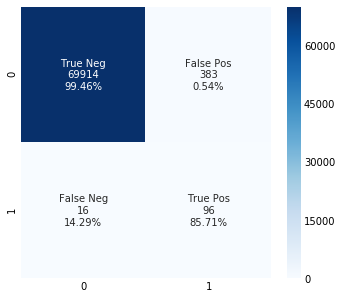

Test Score 0.9359387594511233


C:\Users\Polu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("SMOTEENN")
model = LogisticRegression(C=0.1)
model.fit(dataobj1.X_resampled,dataobj1.y_resampled)
dataobj1.model_evaluation(model)

## Summary

We tried SMOTE, ADASYN and SMOTEENN sampling technique to address the issue with imbalanced data set. We noticed that SOMTE and ADASYN is providing better F1 score and seperatability between classes. Hence, we are proceeding with the SMOTE technique, which also assures that minimum 3% of minority class data is part of total data set.

## Evaluation Metric

We will try with F1 score and start comparaing results with gmeans scoring or other scoring criterias 

In [19]:
from sklearn.metrics import f1_score,roc_auc_score,precision_score,recall_score

dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("SMOTE")

def print_scores(y_true,y_pred):
  print ("F1 Score {:.2f} Micro {:.2f} Macro {:.2f}".format(f1_score(y_true,y_pred),f1_score(y_true,y_pred,average='micro'),f1_score(y_true,y_pred,average='macro')))
  print ("roc_auc_score Score {:.2f} Micro {:.2f} Macro {:.2f}".format(roc_auc_score(y_true,y_pred),roc_auc_score(y_true,y_pred,average='micro'),roc_auc_score(y_true,y_pred,average='macro')))
  print ("precision_score Score {:.2f} Micro {:.2f} Macro {:.2f}".format(precision_score(y_true,y_pred),precision_score(y_true,y_pred,average='micro'),precision_score(y_true,y_pred,average='macro')))
  print ("recall_score Score {:.2f} Micro {:.2f} Macro {:.2f}".format(recall_score(y_true,y_pred),recall_score(y_true,y_pred,average='micro'),recall_score(y_true,y_pred,average='macro')))
  print ("gmean Score {:.2f} Micro {:.2f} Macro {:.2f}".format(gmean(y_true,y_pred),gmean(y_true,y_pred,average='micro'),gmean(y_true,y_pred,average='macro')))    
  
#print(dataobj1.y_resampled.shape)
model = LogisticRegression(C=0.1)
model.fit(dataobj1.X_resampled,dataobj1.y_resampled)

print("\n Oversampled Data Score :")
print_scores(dataobj1.y_resampled,model.predict(dataobj1.X_resampled))

print("\n Original training Data Score :")
print_scores(dataobj1.y_train,model.predict(dataobj1.X_train))

print("\n Original test Data Score :")
print_scores(dataobj1.y_test,model.predict(dataobj1.X_test))

Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64
X Train shape (217215, 30), Y Train Shape (217215, 1), Number of +ve classes Class    6326
dtype: int64

 Oversampled Data Score :
F1 Score 0.90 Micro 0.99 Macro 0.95
roc_auc_score Score 0.92 Micro 0.92 Macro 0.92
precision_score Score 0.98 Micro 0.99 Macro 0.99
recall_score Score 0.83 Micro 0.99 Macro 0.92
gmean Score 0.91 Micro 0.99 Macro 0.92

 Original training Data Score :
F1 Score 0.77 Micro 1.00 Macro 0.89
roc_auc_score Score 0.91 Micro 0.91 Macro 0.91
precision_score Score 0.72 Micro 1.00 Macro 0.86
recall_score Score 0.83 Micro 1.00 Macro 0.91
gmean Score 0.91 Micro 1.00 Macro 0.91

 Original test Data Score :
F1 Score 0.72 Micro 1.00 Macro 0.86
roc_auc_score Score 0.90 Micro 0.90 Macro 0.90
precision_score Scor

### Review Remaks :

With regard to the scoring metric, one of the main challange is to compare the results between oversampled data set with the original train and test data set. After comparing different measures shown above, we can infer to use either ROC AUC Average score or gmeans scores, as both are equally indicating comparable metrics.

However, while referring back to the geometric mean score equation, it is known to be a good metric for dealing with imbalanced data set. Therefore, we have choosen gmeans score to search hyper parameters.

# 4. Model Building 

*   We have choosen SMOTE as sampling technique 
*   Selected Gmean (geometric mean as scoring metric) as scoring metric

We will try with different classification algorithms and tune hyperparameters. Based on the finest results, we will choose the best model.

In [0]:
# we will first try with simple logistic regression 
from searchgrid import set_grid, make_grid_search


dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("SMOTE")

estimator = set_grid(LogisticRegression(penalty='l2'),C=[0.001,0.01,0.1,1])
lst = [estimator]
dataobj1.multiple_estimators(lst,5,"gmeans")
dataobj1.results

Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64
X Train shape (217215, 30), Y Train Shape (217215, 1), Number of +ve classes Class    6326
dtype: int64


,Model,meat_test_score,mean_train_score,parms,scoring,test_0,train_0,test_1,train_1,test_2,train_2,test_3,train_3,test_4,train_4
0,LogisticRegression,0.816471,0.816445,{'C': 0.001},gmeans,0.822554,0.815744,0.799753,0.819882,0.826623,0.812969,0.822574,0.815340,0.810851,0.818291
1,LogisticRegression,0.824755,0.824770,{'C': 0.01},gmeans,0.828816,0.825922,0.805999,0.826712,0.836046,0.818610,0.831128,0.824145,0.821787,0.828461
2,LogisticRegression,0.829005,0.830158,{'C': 0.1},gmeans,0.833518,0.830840,0.808370,0.832400,0.842348,0.822141,0.834268,0.831437,0.826524,0.833972
3,LogisticRegression,0.829945,0.831109,{'C': 1},gmeans,0.835888,0.831437,0.808389,0.833990,0.843138,0.822733,0.834209,0.832430,0.828103,0.834955


In [0]:
#Next model is Random forest with tuned hyperparameter
from sklearn.ensemble import RandomForestClassifier
from searchgrid import set_grid, make_grid_search

dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("SMOTE")

estimator = set_grid(RandomForestClassifier(criterion ="gini",min_samples_split=10,min_samples_leaf =5,
                                            max_samples=0.8,max_features=0.8,warm_start=True,random_state=40,class_weight="balanced"),
                     max_depth =[3,4,5,7],n_estimators =[100])

lst = [estimator]
dataobj1.multiple_estimators(lst,3,"gmeans")
dataobj1.results[dataobj1.results.Model.isin(["RandomForestClassifier"])]

Train data set Shape (212581, 31)
Test data set Shape (70861, 31)
X Train shape (212581, 30), Y Train Shape (212581, 1), Number of +ve classes Class    355
dtype: int64
X Train shape (70861, 30), Y Train Shape (70861, 1), Number of +ve classes Class    118
dtype: int64
X Train shape (218592, 30), Y Train Shape (218592, 1), Number of +ve classes Class    6366
dtype: int64


,Model,meat_test_score,mean_train_score,parms,scoring,test_0,train_0,test_1,train_1,test_2,train_2
0,RandomForestClassifier,0.888614,0.893605,"{'max_depth': 3, 'n_estimators': 100}",gmeans,0.893369,0.896479,0.879010,0.890209,0.893463,0.894127
1,RandomForestClassifier,0.901051,0.905113,"{'max_depth': 4, 'n_estimators': 100}",gmeans,0.901138,0.905835,0.901256,0.907084,0.900759,0.902420
2,RandomForestClassifier,0.920333,0.929622,"{'max_depth': 5, 'n_estimators': 100}",gmeans,0.922146,0.927496,0.917207,0.934835,0.921646,0.926534
3,RandomForestClassifier,0.954489,0.970547,"{'max_depth': 7, 'n_estimators': 100}",gmeans,0.949442,0.971296,0.955582,0.971558,0.958442,0.968787


In [0]:
estimator = set_grid(RandomForestClassifier(criterion ="gini",min_samples_split=10,min_samples_leaf =5,
                                            max_samples=0.8,max_features=0.8,warm_start=True,random_state=40,class_weight="balanced"),
                     max_depth =[7],n_estimators =[200,500])

lst = [estimator]
dataobj1.multiple_estimators(lst,3,"gmeans")
dataobj1.results[dataobj1.results.Model.isin(["RandomForestClassifier"])]

,Model,meat_test_score,mean_train_score,parms,scoring,test_0,train_0,test_1,train_1,test_2,train_2
0,RandomForestClassifier,0.888614,0.893605,"{'max_depth': 3, 'n_estimators': 100}",gmeans,0.893369,0.896479,0.879010,0.890209,0.893463,0.894127
1,RandomForestClassifier,0.901051,0.905113,"{'max_depth': 4, 'n_estimators': 100}",gmeans,0.901138,0.905835,0.901256,0.907084,0.900759,0.902420
2,RandomForestClassifier,0.920333,0.929622,"{'max_depth': 5, 'n_estimators': 100}",gmeans,0.922146,0.927496,0.917207,0.934835,0.921646,0.926534
3,RandomForestClassifier,0.954489,0.970547,"{'max_depth': 7, 'n_estimators': 100}",gmeans,0.949442,0.971296,0.955582,0.971558,0.958442,0.968787
0,RandomForestClassifier,0.954713,0.970893,"{'max_depth': 7, 'n_estimators': 200}",gmeans,0.950298,0.971896,0.955438,0.971137,0.958401,0.969647
1,RandomForestClassifier,0.955750,0.971075,"{'max_depth': 7, 'n_estimators': 500}",gmeans,0.952240,0.971737,0.956444,0.971689,0.958565,0.969798


In [0]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = set_grid(GradientBoostingClassifier(learning_rate =0.01,min_samples_split=10,min_samples_leaf =5,validation_fraction=0.2,
                                            subsample=0.5,max_features=0.7,random_state=40,tol=0.001,n_iter_no_change=5),
                     max_depth =[2,3,5,7],n_estimators =[500])

lst = [estimator]
dataobj1.multiple_estimators(lst,3,"gmeans")
dataobj1.results[dataobj1.results.Model.isin(["GradientBoostingClassifier"])]

,Model,meat_test_score,mean_train_score,parms,scoring,test_0,train_0,test_1,train_1,test_2,train_2,test_3,train_3,test_4,train_4
0,GradientBoostingClassifier,0.824271,0.826737,"{'max_depth': 2, 'n_estimators': 500}",gmeans,0.820010,0.825494,0.832362,0.824991,0.820441,0.829726,NaN,NaN,NaN,NaN
1,GradientBoostingClassifier,0.839462,0.840960,"{'max_depth': 3, 'n_estimators': 500}",gmeans,0.839942,0.841683,0.845148,0.837888,0.833298,0.843311,NaN,NaN,NaN,NaN
2,GradientBoostingClassifier,0.851039,0.854128,"{'max_depth': 5, 'n_estimators': 500}",gmeans,0.850886,0.855941,0.856111,0.849340,0.846120,0.857104,NaN,NaN,NaN,NaN
3,GradientBoostingClassifier,0.867799,0.875886,"{'max_depth': 7, 'n_estimators': 500}",gmeans,0.867037,0.876607,0.871255,0.870437,0.865105,0.880614,NaN,NaN,NaN,NaN


In [0]:
#Next model is gradient boost with tuned hyperparameter
from sklearn.ensemble import GradientBoostingClassifier


estimator = set_grid(GradientBoostingClassifier(learning_rate =0.01,min_samples_split=10,min_samples_leaf =5,validation_fraction=0.2,
                                            subsample=0.8,max_features=0.8,random_state=40,tol=0.0001,n_iter_no_change=5),
                     max_depth =[7],n_estimators =[500])

lst = [estimator]
dataobj1.multiple_estimators(lst,3,"gmeans")
dataobj1.results[dataobj1.results.Model.isin(["GradientBoostingClassifier"])]

,Model,meat_test_score,mean_train_score,parms,scoring,test_0,train_0,test_1,train_1,test_2,train_2
0,GradientBoostingClassifier,0.901554,0.928,"{'max_depth': 7, 'n_estimators': 500}",gmeans,0.893522,0.925676,0.911456,0.931896,0.899684,0.926429


Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64
X Train shape (217215, 30), Y Train Shape (217215, 1), Number of +ve classes Class    6326
dtype: int64
Train cross validation 
 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    210889
           1       0.21      0.99      0.35       336

    accuracy                           0.99    211225
   macro avg       0.61      0.99      0.67    211225
weighted avg       1.00      0.99      1.00    211225



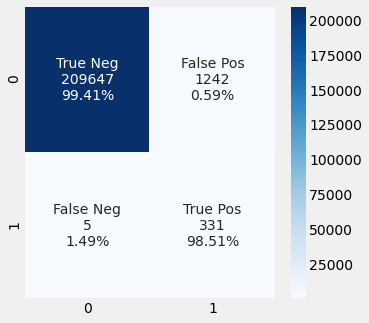

Train Score 0.9896046345394672
test cross validation 
 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     70297
           1       0.19      0.85      0.30       112

    accuracy                           0.99     70409
   macro avg       0.59      0.92      0.65     70409
weighted avg       1.00      0.99      1.00     70409

['99.41%', '0.59%', '15.18%', '84.82%']


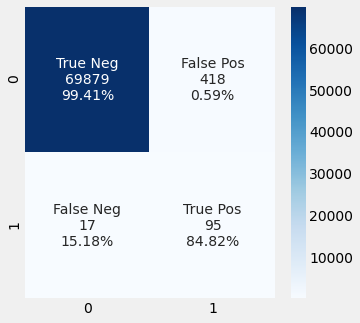

Test Score 0.9896046345394672


In [0]:
dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("SMOTE")
model = RandomForestClassifier(criterion ="gini",min_samples_split=10,min_samples_leaf =5,
                                            max_samples=0.8,max_features=0.8,warm_start=True,random_state=40,class_weight="balanced",max_depth =7,n_estimators =500)
dataobj1.model_evaluation(model)

Train cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210889
           1       0.85      1.00      0.92       336

    accuracy                           1.00    211225
   macro avg       0.93      1.00      0.96    211225
weighted avg       1.00      1.00      1.00    211225



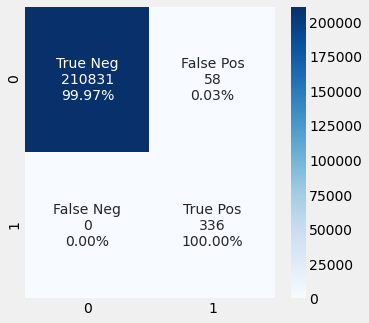

Train Score 0.9998624774444652
test cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70297
           1       0.72      0.79      0.76       112

    accuracy                           1.00     70409
   macro avg       0.86      0.90      0.88     70409
weighted avg       1.00      1.00      1.00     70409

['99.95%', '0.05%', '20.54%', '79.46%']


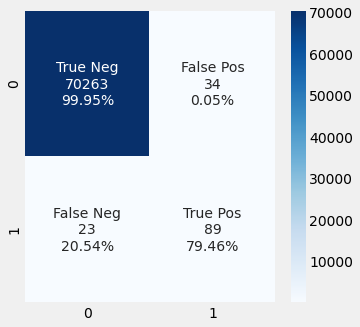

Test Score 0.9998624774444652


In [0]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate =0.01,min_samples_split=10,min_samples_leaf =3,validation_fraction=0.3,
                                            subsample=0.8,max_features=0.8,random_state=40,tol=0.0001,n_iter_no_change=5,max_depth =7,n_estimators =1000)
dataobj1.model_evaluation(model)
    

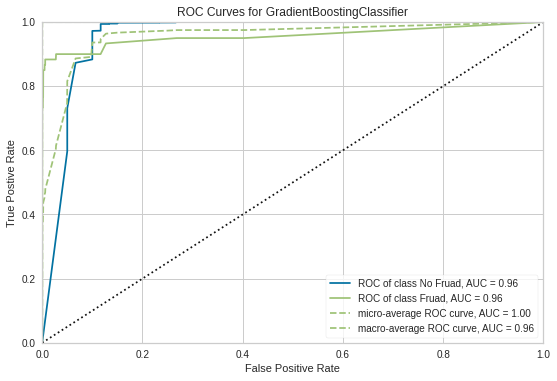

In [0]:
from yellowbrick.classifier.rocauc import roc_auc

roc_auc(model,dataobj1.X_train,dataobj1.y_train,X_test=dataobj1.X_test,y_test=dataobj1.y_test,classes=["No Fruad","Fruad"])

In [0]:
#Next model is lg boost with tuned hyperparameter
import lightgbm as lgb
estimator = set_grid(lgb.LGBMClassifier(num_leaves=31,learning_rate=0.01,subsample=0.7,class_weight={1:0.7,0:0.3},reg_alpha =0.01,random_state =42,min_child_samples=10) ,n_estimators =[200,500,1000],max_depth=[2,5,7])
lst = [estimator]
dataobj1.multiple_estimators(lst,3,"gmeans")
dataobj1.results[dataobj1.results.Model.isin(["LGBMClassifier"])]

,Model,meat_test_score,mean_train_score,parms,scoring,test_0,train_0,test_1,train_1,test_2,train_2
0,LGBMClassifier,0.830518,0.830599,"{'max_depth': 2, 'n_estimators': 200}",gmeans,0.831298,0.831556,0.834625,0.829620,0.825631,0.830621
1,LGBMClassifier,0.850102,0.851272,"{'max_depth': 2, 'n_estimators': 500}",gmeans,0.851582,0.852216,0.853145,0.848877,0.845578,0.852722
2,LGBMClassifier,0.860346,0.862839,"{'max_depth': 2, 'n_estimators': 1000}",gmeans,0.860099,0.865200,0.863604,0.859033,0.857335,0.864282
3,LGBMClassifier,0.864361,0.870143,"{'max_depth': 5, 'n_estimators': 200}",gmeans,0.862122,0.871274,0.868411,0.865298,0.862551,0.873857
4,LGBMClassifier,0.899053,0.915591,"{'max_depth': 5, 'n_estimators': 500}",gmeans,0.898534,0.918249,0.904834,0.913705,0.893792,0.914819
5,LGBMClassifier,0.956224,0.979243,"{'max_depth': 5, 'n_estimators': 1000}",gmeans,0.953523,0.980573,0.960668,0.978017,0.954479,0.979139
6,LGBMClassifier,0.897596,0.918114,"{'max_depth': 7, 'n_estimators': 200}",gmeans,0.893793,0.914602,0.902387,0.917651,0.896610,0.922089
7,LGBMClassifier,0.946707,0.978706,"{'max_depth': 7, 'n_estimators': 500}",gmeans,0.944040,0.978140,0.946856,0.978651,0.949226,0.979328
8,LGBMClassifier,0.977349,0.998465,"{'max_depth': 7, 'n_estimators': 1000}",gmeans,0.977412,0.998089,0.982943,0.998542,0.971693,0.998765


Train data set Shape (211225, 31)
Test data set Shape (70409, 31)
X Train shape (211225, 30), Y Train Shape (211225, 1), Number of +ve classes Class    336
dtype: int64
X Train shape (70409, 30), Y Train Shape (70409, 1), Number of +ve classes Class    112
dtype: int64
X Train shape (217215, 30), Y Train Shape (217215, 1), Number of +ve classes Class    6326
dtype: int64
Train cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210889
           1       0.94      1.00      0.97       336

    accuracy                           1.00    211225
   macro avg       0.97      1.00      0.98    211225
weighted avg       1.00      1.00      1.00    211225



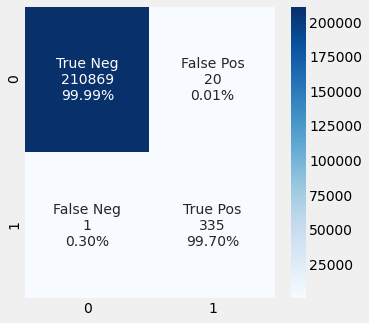

Train Score 0.9984634470802839
test cross validation 
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70297
           1       0.83      0.81      0.82       112

    accuracy                           1.00     70409
   macro avg       0.91      0.91      0.91     70409
weighted avg       1.00      1.00      1.00     70409

['99.97%', '0.03%', '18.75%', '81.25%']


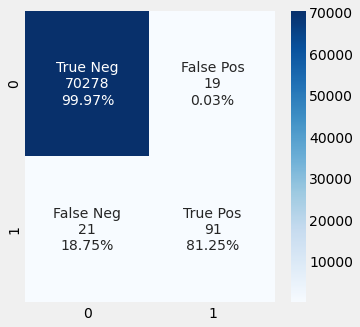

Test Score 0.9984634470802839


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

model = lgb.LGBMClassifier(num_leaves=31,learning_rate=0.01,subsample=0.7,class_weight={1:0.7,0:0.3},reg_alpha =0.01,random_state =42,min_child_samples=10,n_estimators=1000,max_depth=7)

dataobj1 = data_object(card_filtered)
dataobj1.original_data["Time"] =dataobj1.original_data.Time/3600
dataobj1.traintestsplit()
dataobj1.data_scaling(["Amount","Time"])
dataobj1.resampling("SMOTE")
dataobj1.model_evaluation(model)

In [27]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [0]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dataobj1.X_train)

In [28]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], dataobj1.X_train.iloc[0,:])

In [0]:
print("\n Oversampled Data Score :")
print_scores(dataobj1.y_resampled,model.predict(dataobj1.X_resampled))

print("\n Original training Data Score :")
print_scores(dataobj1.y_train,model.predict(dataobj1.X_train))

print("\n Original test Data Score :")
print_scores(dataobj1.y_test,model.predict(dataobj1.X_test))


 Oversampled Data Score :
F1 Score 1.00 Micro 1.00 Macro 1.00
roc_auc_score Score 1.00 Micro 1.00 Macro 1.00
precision_score Score 1.00 Micro 1.00 Macro 1.00
recall_score Score 1.00 Micro 1.00 Macro 1.00
gmean Score 1.00 Micro 1.00 Macro 1.00

 Original training Data Score :
F1 Score 0.97 Micro 1.00 Macro 0.98
roc_auc_score Score 1.00 Micro 1.00 Macro 1.00
precision_score Score 0.94 Micro 1.00 Macro 0.97
recall_score Score 1.00 Micro 1.00 Macro 1.00
gmean Score 1.00 Micro 1.00 Macro 1.00

 Original test Data Score :
F1 Score 0.82 Micro 1.00 Macro 0.91
roc_auc_score Score 0.91 Micro 0.91 Macro 0.91
precision_score Score 0.83 Micro 1.00 Macro 0.91
recall_score Score 0.81 Micro 1.00 Macro 0.91
gmean Score 0.90 Micro 1.00 Macro 0.91


Train Result


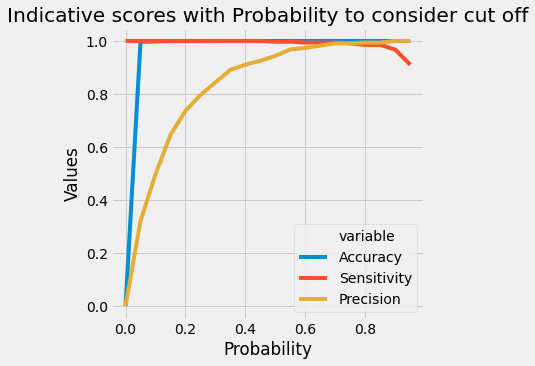

In [0]:
predict_prob=model.predict_proba(dataobj1.X_train)
dataobj1.display_stats("Train",predict_prob[:,1],dataobj1.y_train)
#display_stats(self,type,preditc_prob,y_true,verbose=0):

### Review summary 

Above indicates that using 70% of predict probability is an optimal choice to seperate classes between fruad and non fraud which will slightly increase the precesion comparig with defualt 50% probability. 

In [0]:
#For Financial Analysis

data_X = pd.concat([dataobj1.X_train,dataobj1.X_test])
data_y = pd.concat([dataobj1.y_train,dataobj1.y_test])

print("\n Entire Base:")
pred =[1 if j>=0.70 else 0 for j in model.predict_proba(data_X)[:,1]]
print_scores(data_y,pred)

print("\n Confusion Matrix:")
# pred =[1 if j>=0.6 else 0 for j in ,model.predict_proba(data_X)[:,1]]
# print_scores(data_y,pred)
display(confusion_matrix(data_y,pred))

data =data_X.copy()
data["Original"] = data_y.Class
data["Predicted"] =pred
data["key"] = data.index
_temp=dataobj1.original_data[["Amount"]]
_temp["key"] = _temp.index
data=pd.merge(data,_temp,on="key",how="inner")
_temp=data.groupby(["Original","Predicted"])["Amount_y"].sum()
_temp=_temp.reset_index()
pd.options.display.float_format = '{:,.2f}'.format
_temp.head()


 Entire Base:
F1 Score 0.96 Micro 1.00 Macro 0.98
roc_auc_score Score 0.97 Micro 0.97 Macro 0.97
precision_score Score 0.97 Micro 1.00 Macro 0.99
recall_score Score 0.95 Micro 1.00 Macro 0.97
gmean Score 0.97 Micro 1.00 Macro 0.97

 Confusion Matrix:


array([[281173,     13],
       [    23,    425]])

,Original,Predicted,Amount_y
0,0,0,"23,764,298.10"
1,0,1,671.69
2,1,0,"5,063.71"
3,1,1,"53,527.68"


# Training with Neural Network Implimentation

In [0]:
import tensorflow as tf
#from tf.keras.layers import Sequential,Dense

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')     
]


nb_epoch = 100
batch_size = 128
input_dim = dataobj1.X_resampled.shape[1]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu',input_dim=dataobj1.X_resampled.shape[1]))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(128, activation='relu',input_dim=dataobj1.X_resampled.shape[1]))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(512, activation='relu',input_dim=dataobj1.X_resampled.shape[1]))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                1984      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_39 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1024)            

In [0]:
fit=model.fit(x=dataobj1.X_resampled,y=dataobj1.y_resampled,batch_size=5000,epochs=30,verbose=1,validation_split=0.3)

Epoch 1/30
31/31 [==============================] - 1s 35ms/step - loss: 0.0758 - tp: 0.0000e+00 - fp: 837.0000 - tn: 150957.0000 - fn: 256.0000 - accuracy: 0.9928 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4498 - val_loss: 0.8954 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 59095.0000 - val_fn: 6070.0000 - val_accuracy: 0.9069 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6370
Epoch 2/30
31/31 [==============================] - 0s 13ms/step - loss: 0.0148 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 151794.0000 - fn: 256.0000 - accuracy: 0.9983 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6814 - val_loss: 0.4303 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 59095.0000 - val_fn: 6070.0000 - val_accuracy: 0.9069 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9283
Epoch 3/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0077 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 151794.0000 - fn: 256.0000 - accuracy: 0

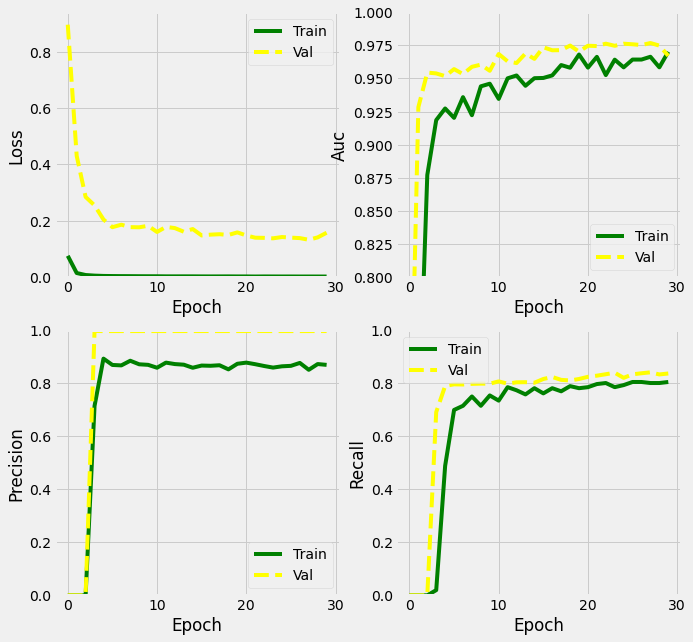

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color="green", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="yellow", linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plt.figure(figsize=(10,10))
plot_metrics(fit)

In [0]:
results = model.predict(dataobj1.X_train)

print_scores(dataobj1.y_train,tf.round(results))
print(confusion_matrix(dataobj1.y_train,tf.round(results)))

print("\n \n")
results = model.predict(dataobj1.X_test)
print_scores(dataobj1.y_test,tf.round(results))
confusion_matrix(dataobj1.y_test,tf.round(results))

F1 Score 0.85 Micro 1.00 Macro 0.92
roc_auc_score Score 0.92 Micro 0.92 Macro 0.92
precision_score Score 0.86 Micro 1.00 Macro 0.93
recall_score Score 0.83 Micro 1.00 Macro 0.92
gmean Score 0.91 Micro 1.00 Macro 0.92
[[210845     44]
 [    56    280]]

 

F1 Score 0.78 Micro 1.00 Macro 0.89
roc_auc_score Score 0.89 Micro 0.89 Macro 0.89
precision_score Score 0.78 Micro 1.00 Macro 0.89
recall_score Score 0.78 Micro 1.00 Macro 0.89
gmean Score 0.88 Micro 1.00 Macro 0.89


array([[70272,    25],
       [   25,    87]])

# Financial Analysis


Conlcusion: We have tried modelling the data based on simple logistic regression, random forest with hypertuning, gradient boosting with hypertuning, lg boosting with hypertuning and NN. Based on the results of model validated on Test data, we have found that the best score of evaluation metric is returned by LG Boost Model. Hence, we will undertake the cost benefit analysis based on LG Boost model where the results of both the train and test data has been consolidated for evaluation purpose:

1. Total Fraud Prediction that the model has made (TP+FP) = 438 (425+13)
2. Cost of making call to customer = INR 10 per call
3. EUR INR Conversion Rate = (EUR 1 = INR 80)
4. Savings by making correct calls = <font color=green> <b> EUR 53,527.68 </b> </font>
5. Loss by making incorrect calls = <font color=red> <b> EUR 5,063.71 </b> </font> 
6. Total Savings by the Bank using the model is = EUR 53,527.68 - ((425+13) * 10)/80 + 5,063.71) = <font color=green> <b> EUR 58,536.64 approx. </b> </font>